git clone https://github.com/ChaoningZhang/MobileSAM

In [37]:
import torch 
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image

from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "../MobileSAM/weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()



Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0-1): 2 x MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
 

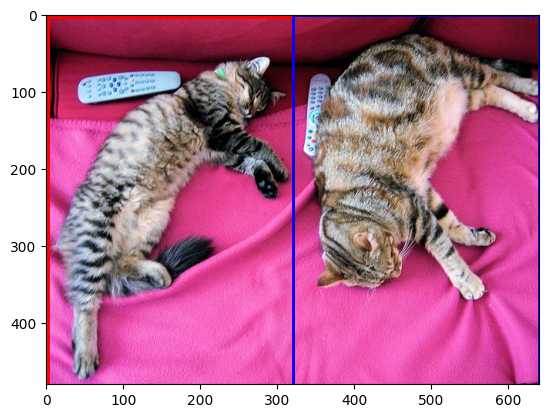

In [38]:
import requests
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image = np.array(image)

x_min, y_min, x_max, y_max = 2, 2, image.shape[1] //2 , image.shape[0]

x2_min, y2_min, x2_max, y2_max = image.shape[1] // 2, 0 , image.shape[1], image.shape[0]

plt.imshow(image)
plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2))
plt.gca().add_patch(plt.Rectangle((x2_min, y2_min), x2_max - x2_min, y2_max - y2_min, fill=False, color='blue', linewidth=2))
plt.show()


In [39]:
predictor = SamPredictor(mobile_sam)


In [40]:
print(image.shape)
predictor.set_image(image)


(480, 640, 3)


In [52]:
masks, _, _ = predictor.predict(box=np.array([x_min, y_min, x_max, y_max]))
mask2, _, _ = predictor.predict(box=np.array([x2_min, y2_min, x2_max, y2_max]))

print(mask2.shape)


(3, 512, 512)


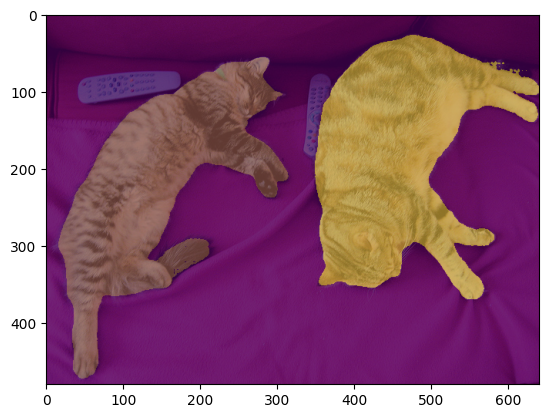

In [42]:
# visualize the mask
plt.imshow(image)
plt.imshow(masks[0], alpha=0.5)
plt.imshow(mask2[0], alpha=0.5)
plt.show()

In [51]:
# do inference test
import time

feature_inference_times = []
predict_times = []
n_iters = 100
image_size = (512, 512)
n_bboxes = 5

imgs = np.zeros((n_iters, image_size[0], image_size[1], 3))
for i in range(n_iters):
    start_time = time.time()
    img = imgs[i]
    predictor.set_image(img)
    image_set_time = time.time()
    for _ in range(n_bboxes):
        x_min, y_min, x_max, y_max = np.random.randint(0, image_size[0]), np.random.randint(0, image_size[1]), np.random.randint(0, image_size[0]), np.random.randint(0, image_size[1])
        predictor.predict(box=np.array([x_min, y_min, x_max, y_max]))
    end_time = time.time()
    feature_inference_times.append(image_set_time - start_time)
    predict_times.append(end_time - image_set_time)


# print mean +- std
total_times = np.array(feature_inference_times) + np.array(predict_times)
print(f"feature inference time: {np.mean(feature_inference_times)}, Std: {np.std(feature_inference_times)}")
print(f"predict time / box: {np.mean(predict_times) / n_bboxes}, Std: {np.std(predict_times) / n_bboxes}")
print(f"predict time: {np.mean(predict_times)}, Std: {np.std(predict_times)}")
print(f"total time: {np.mean(total_times)}, Std: {np.std(total_times)}")

feature inference time: 0.010700554847717285, Std: 0.0001583352369606905
predict time / box: 0.002824557304382324, Std: 2.069459600886917e-05
predict time: 0.014122786521911622, Std: 0.00010347298004434585
total time: 0.024823341369628906, Std: 0.00018311448534481431
